In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import numpy as np

Optimal number of features: 17
Selected features: Index(['ρ', 'Vp+ρ', 'Vs+ρ', 'Vp-Vs', 'Vp-ρ', 'Vs-ρ', 'VpVs', 'Vpρ', 'Vsρ',
       'Vp/ρ', 'Vs/ρ', 'Vp/Vs', 'σ', 'λ', 'μ', 'ρλ', 'ρμ'],
      dtype='object')


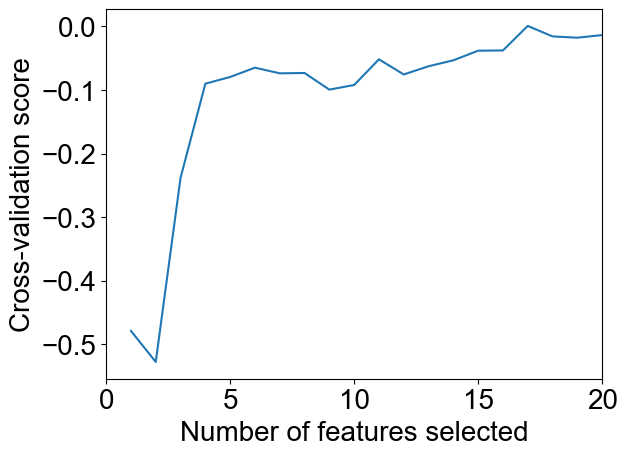

In [2]:
# Load dataset
file_path = 'CaO_dataset.xlsx'
data = pd.read_excel(file_path)

# Separate features and target
X = data.iloc[:, 4:24]
y = data.iloc[:, 24]

# IQR
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
mask = (y >= lower_bound) & (y <= upper_bound)
X = X[mask]
y = y[mask]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

# Define base model for feature selection
model = xgb.XGBRegressor(colsample_bytree=0.8, eta=0.04, max_depth=8, n_estimators=250, subsample=0.7)

# Feature selection using RFECV
rfecv = RFECV(estimator=model, step=1, cv=10, min_features_to_select=1)
rfecv = rfecv.fit(X, y)

# Print RFECV results
print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features: {X.columns[rfecv.support_]}")

# Plot RFECV results
plt.figure()
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 20})
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.xticks(range(0, 21, 5))
plt.xlim(0, 20)
plt.savefig('RFECV.svg', format='svg', bbox_inches='tight')
plt.show()

In [3]:
# Select features
selected_features = X.columns[rfecv.support_]
X_new = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=43)

In [4]:
# Custom SMOTE for regression
def smote_regression(X, y, k=5, n_samples=800, random_state=43):
    X = np.array(X)
    y = np.array(y)
    np.random.seed(random_state)
    nn = NearestNeighbors(n_neighbors=k+1)
    nn.fit(X)
    neighbors_idx = nn.kneighbors(X, return_distance=False)[:, 1:]
    X_resampled = np.zeros((n_samples, X.shape[1]))
    y_resampled = np.zeros(n_samples)

    for i in range(n_samples):
        base_idx = np.random.randint(0, X.shape[0])
        if neighbors_idx[base_idx].size == 0:
            continue
        neighbor_idx = np.random.choice(neighbors_idx[base_idx])
        lam = np.random.rand()
        X_resampled[i] = X[base_idx] + lam * (X[neighbor_idx] - X[base_idx])
        y_resampled[i] = y[base_idx] + lam * (y[neighbor_idx] - y[base_idx])

    X_combined = np.vstack((X, X_resampled))
    y_combined = np.concatenate((y, y_resampled))
    return X_combined, y_combined

# Apply SMOTE
X_train, y_train = smote_regression(X_train, y_train, k=5, n_samples=800, random_state=43)

d:\Applications\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Applications\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "d:\Applications\Anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Applications\Anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "d:\Applications\Anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
  

In [5]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test.values)

In [6]:
# Define models and hyperparameters
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'param_grid': {}
    },
    'Ridge': {
        'model': Ridge(),
        'param_grid': {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'param_grid': {
            'n_neighbors': [5, 7, 9, 11, 13],
            'weights': ['uniform'],
            'algorithm': ['ball_tree', 'kd_tree'],
            'p': [1, 2]
        }
    },    
    'SVR': {
        'model': SVR(),
        'param_grid': {
            'kernel': ['linear', 'rbf'],
            'C': [0.1, 1, 10, 100, 1000],
            'gamma': ['scale', 'auto']
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'param_grid': {
            'n_estimators': [300, 400, 600],
            'max_depth': [10, 12, 14],
            'min_samples_split': [20, 25],
            'min_samples_leaf': [10, 12],
            'max_features': [0.5, 0.6],
            'max_samples': [0.7, 0.8],
            'ccp_alpha': [0.02, 0.03]
        }
    },
    'XGBoost': {
        'model': xgb.XGBRegressor(objective='reg:squarederror'),
        'param_grid': {
            'max_depth': [5, 6],
            'eta': [0.005, 0.01],
            'subsample': [0.6, 0.7],
            'colsample_bytree': [0.5, 0.6],
            'n_estimators': [300, 400, 600],
            'reg_alpha': [0.7, 1.0],
            'reg_lambda': [1.5, 2.0],
            'gamma': [0.1, 0.2],
            'min_child_weight': [10, 15]
        }
    }    
}

# Train models and evaluate
best_models = {}
for name, model_info in models.items():
    print(f"Training {name}...")
    grid_search = GridSearchCV(estimator=model_info['model'], param_grid=model_info['param_grid'], cv=10, scoring='r2', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    cv_score = grid_search.best_score_
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Cross-validation score for {name}: {cv_score:.2f}")

Training LinearRegression...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters for LinearRegression: {}
Cross-validation score for LinearRegression: 0.46
Training Ridge...
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best parameters for Ridge: {'alpha': 0.001}
Cross-validation score for Ridge: 0.46
Training KNN...
Fitting 10 folds for each of 20 candidates, totalling 200 fits


Best parameters for KNN: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Cross-validation score for KNN: 0.69
Training SVR...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters for SVR: {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Cross-validation score for SVR: 0.61
Training RandomForest...
Fitting 10 folds for each of 288 candidates, totalling 2880 fits
Best parameters for RandomForest: {'ccp_alpha': 0.02, 'max_depth': 14, 'max_features': 0.5, 'max_samples': 0.8, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 400}
Cross-validation score for RandomForest: 0.67
Training XGBoost...
Fitting 10 folds for each of 768 candidates, totalling 7680 fits
Best parameters for XGBoost: {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.1, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 600, 'reg_alpha': 0.7, 'reg_lambda': 1.5, 'subsample': 0.7}
Cross-validation score for XGBoost: 0.73


--- LinearRegression ---
Training MSE: 9.69, RMSE: 3.11, R²: 0.48, MAE: 2.27
CV MSE: 10.06 (+/- 2.67), RMSE: 3.17 (+/- 1.63), R²: 0.46 (+/- 0.10), MAE: 2.30 (+/- 0.32)
Test MSE: 9.47, RMSE: 3.08, R²: 0.50, MAE: 2.36


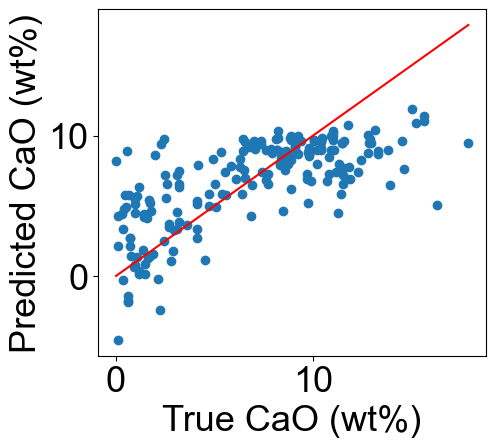

--- Ridge ---
Training MSE: 9.82, RMSE: 3.13, R²: 0.47, MAE: 2.28
CV MSE: 10.11 (+/- 2.51), RMSE: 3.18 (+/- 1.59), R²: 0.46 (+/- 0.09), MAE: 2.31 (+/- 0.31)
Test MSE: 9.66, RMSE: 3.11, R²: 0.49, MAE: 2.37


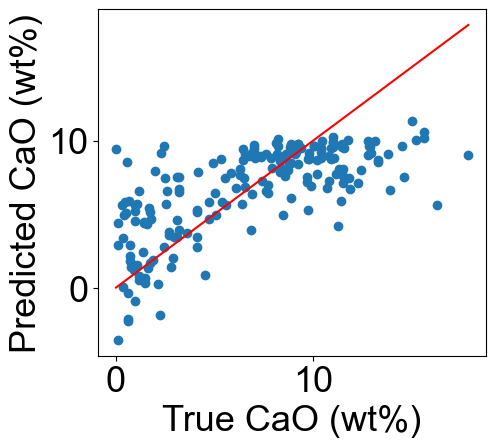

--- KNN ---
Training MSE: 3.62, RMSE: 1.90, R²: 0.80, MAE: 1.15
CV MSE: 5.98 (+/- 2.72), RMSE: 2.45 (+/- 1.65), R²: 0.69 (+/- 0.12), MAE: 1.55 (+/- 0.38)
Test MSE: 8.19, RMSE: 2.86, R²: 0.57, MAE: 1.92


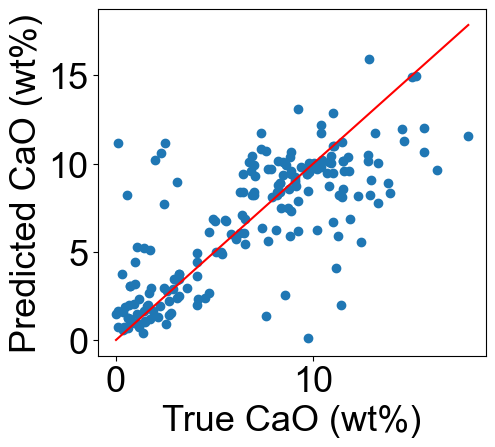

--- SVR ---
Training MSE: 6.22, RMSE: 2.49, R²: 0.66, MAE: 1.54
CV MSE: 7.30 (+/- 2.52), RMSE: 2.70 (+/- 1.59), R²: 0.61 (+/- 0.10), MAE: 1.72 (+/- 0.30)
Test MSE: 8.16, RMSE: 2.86, R²: 0.57, MAE: 1.88


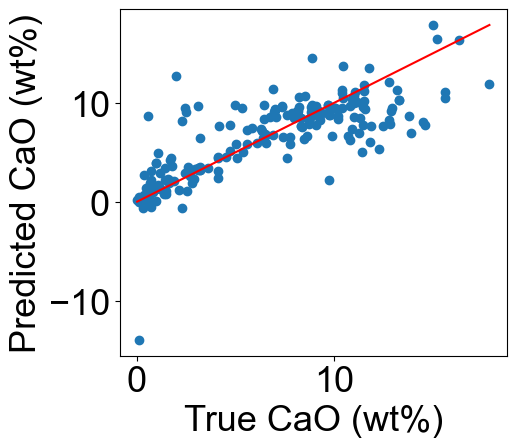

--- RandomForest ---
Training MSE: 4.37, RMSE: 2.09, R²: 0.76, MAE: 1.42
CV MSE: 6.31 (+/- 2.32), RMSE: 2.51 (+/- 1.52), R²: 0.67 (+/- 0.10), MAE: 1.70 (+/- 0.32)
Test MSE: 6.75, RMSE: 2.60, R²: 0.64, MAE: 1.82


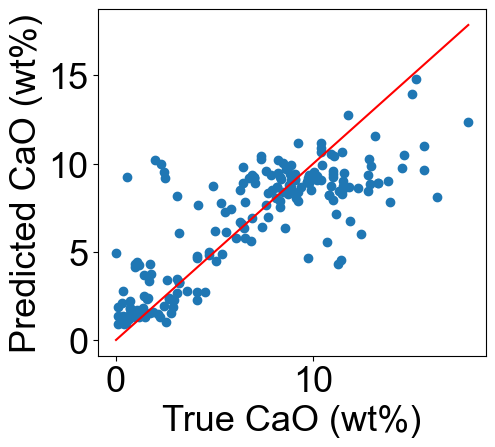

--- XGBoost ---
Training MSE: 2.16, RMSE: 1.47, R²: 0.88, MAE: 1.01
CV MSE: 5.16 (+/- 2.33), RMSE: 2.27 (+/- 1.52), R²: 0.73 (+/- 0.10), MAE: 1.50 (+/- 0.32)
Test MSE: 6.48, RMSE: 2.55, R²: 0.66, MAE: 1.77


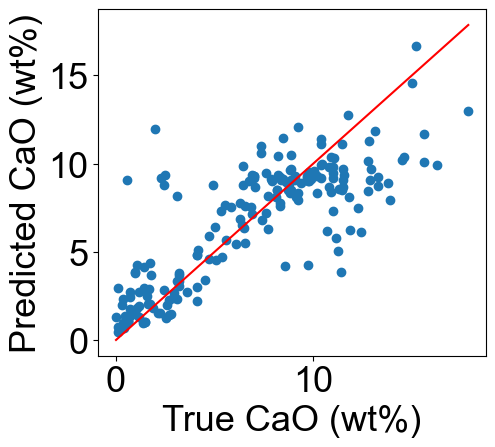

In [7]:
# Compare model performance
for name, model in best_models.items():
    y_train_pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)

    cv_mse = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    cv_r2 = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
    cv_mae = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

    mse_mean = -cv_mse.mean()
    mse_std = cv_mse.std()
    rmse_mean = np.sqrt(mse_mean)
    rmse_std = np.sqrt(mse_std)
    r2_mean = cv_r2.mean()
    r2_std = cv_r2.std()
    mae_mean = -cv_mae.mean()
    mae_std = cv_mae.std()

    y_pred = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)

    print(f"--- {name} ---")
    print(f"Training MSE: {mse_train:.2f}, RMSE: {rmse_train:.2f}, R²: {r2_train:.2f}, MAE: {mae_train:.2f}")
    print(f"CV MSE: {mse_mean:.2f} (+/- {mse_std:.2f}), RMSE: {rmse_mean:.2f} (+/- {rmse_std:.2f}), R²: {r2_mean:.2f} (+/- {r2_std:.2f}), MAE: {mae_mean:.2f} (+/- {mae_std:.2f})")
    print(f"Test MSE: {mse_test:.2f}, RMSE: {rmse_test:.2f}, R²: {r2_test:.2f}, MAE: {mae_test:.2f}")

    # Plot predicted vs true values
    plt.figure(figsize=(5, 4.5))
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams.update({'font.size': 26})
    plt.scatter(y_test, y_pred, label=f'{name} Predictions')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
    plt.xlabel('True CaO (wt%)')
    plt.ylabel('Predicted CaO (wt%)')
    plt.savefig(f'{name}_prediction.svg', format='svg', bbox_inches='tight') 
    plt.show()